In [1]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset_new_v2 import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep_new_v2 import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['legend.fontsize']=11

fig_width = 6
fig_width_big = 12

In [2]:

folder_path = '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final/'
# folder_path = '../../../in-context-bldc-data/simulated/50_percent_with_alfa_beta_alt'


In [3]:
list_of_folders = glob.glob(os.path.join(folder_path, '*'))[:6]
print(list_of_folders)
identifiers = [list_of_folders[i].split("_")[-2][-9:] for i in range(len(list_of_folders))]
print(identifiers)

#### inertias [e-4]: I5 = 0.7, I13 = 1.4, I15 = 3.1, I9 = 5.8, I11 = 6.8, I7 = 8.8
order = [0, 4, 5, 2, 3, 1]
list_of_folders = [list_of_folders[j] for j in order]
identifiers = [identifiers[j] for j in order]
print(list_of_folders)
print(identifiers)

['../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia05_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia07_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia09_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia11_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia13_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia15_ki-0.0029-kp-3.0000']
['inertia05', 'inertia07', 'inertia09', 'inertia11', 'inertia13', 'inertia15']
['../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia05_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia13_ki-0.0029-kp-3.0000', '../data/CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia15_ki-0.0029-kp-3.0000', '../data/CL_experim

In [9]:

profile_list_meta = []
profile_list_ekf = []
profile_list_real = []

for exp_idx in range(len(list_of_folders)):
    profile_config_meta = []
    profile_config_ekf = []
    profile_config_real = []
    exp_path = list_of_folders[exp_idx]
    csv_list = glob.glob(os.path.join(exp_path, "*.csv"))
    for file in csv_list:

        df = pd.read_csv(file)
        profile_config_real.append(df["omega"].to_numpy())
        profile_config_meta.append(df["omega_meta"].to_numpy())
        profile_config_ekf.append(df["omega_ekf"].to_numpy())

    profile_list_real.append(  np.row_stack(profile_config_real)    )
    profile_list_meta.append(  np.row_stack(profile_config_meta)    )
    profile_list_ekf.append(   np.row_stack(profile_config_ekf)     )
    # print(np.row_stack(profile_config_real).shape)

# print(rmse_list_meta)


profile_full_real = np.stack(profile_list_real)
profile_full_meta = np.stack(profile_list_meta)
profile_full_ekf = np.stack(profile_list_ekf)
config_number, exp_number, exp_length = profile_full_meta.shape
print(config_number)
print(exp_number)
print(exp_length)

6
15
2201


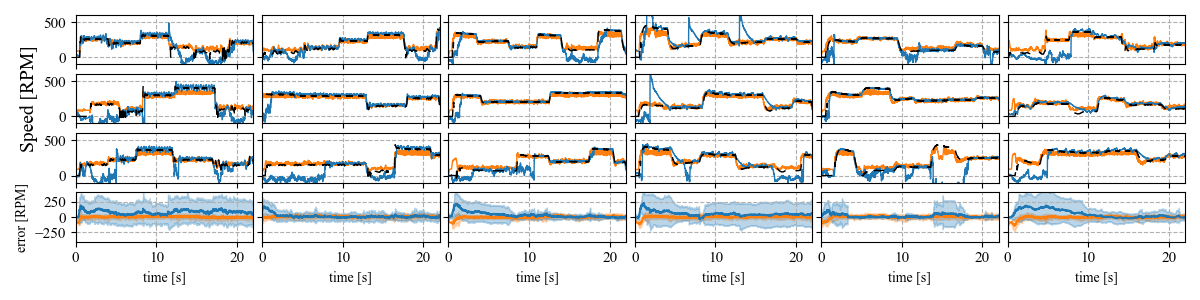

In [61]:
fig, axes = plt.subplots(4, 6, figsize=(12, 3), sharex=True)

for config_idx in range(config_number):
# for config_idx in range(1):
    for i in range(3):

        axes[i,config_idx].plot(df["t"],profile_full_meta[config_idx,i,:], label=r"$\hat{\omega}_{\mathcal{F}}$", color="tab:orange", linewidth = 1)
        axes[i,config_idx].plot(df["t"],profile_full_ekf[config_idx,i,:], label=r"$\hat{\omega}_{EKF}$", color="tab:blue", linewidth = 1)
        axes[i,config_idx].plot(df["t"],profile_full_real[config_idx,i,:], label=r"$\omega$", color="k", linestyle=(0, (8, 8)), linewidth = 1)
        axes[i,config_idx].set_ylim([-100, 600])
        if config_idx != 0:
            axes[i,config_idx].set_yticklabels([])
        elif i == 1:
            axes[i,config_idx].set_ylabel("Speed [RPM]")


    avg_error_meta = (profile_full_real[config_idx,:,:] - profile_full_meta[config_idx,:,:]).mean(axis = 0)
    avg_error_ekf = (profile_full_real[config_idx,:,:] - profile_full_ekf[config_idx,:,:]).mean(axis = 0)

    std_error_meta = (profile_full_real[config_idx,:,:] - profile_full_meta[config_idx,:,:]).std(axis = 0)
    std_error_ekf = (profile_full_real[config_idx,:,:] - profile_full_ekf[config_idx,:,:]).std(axis = 0)
    


    axes[-1, config_idx].plot(df["t"],avg_error_meta, label=r"$e_{\mathcal{F}}$", color="tab:orange")
    axes[-1, config_idx].fill_between(
        df["t"], 
        avg_error_meta + std_error_meta, 
        avg_error_meta - std_error_meta, 
        color='tab:orange', 
        alpha=0.3
    )

    axes[-1, config_idx].plot(df["t"],avg_error_ekf, label=r"$e_{EKF}$", color="tab:blue")
    axes[-1, config_idx].fill_between(
        df["t"], 
        avg_error_ekf + std_error_ekf, 
        avg_error_ekf - std_error_ekf, 
        color='tab:blue', 
        alpha=0.3
    )
    axes[-1,config_idx].set_xlabel("time [s]", fontsize=10)
    if config_idx != 0:
        axes[-1,config_idx].set_yticklabels([])
    else:
        axes[-1,config_idx].set_ylabel("error [RPM]", fontsize=10)

    axes[-1,config_idx].set_ylim([-400, 400])
# handles, labels = axes[0, 3].get_legend_handles_labels()
# fig.legend(handles, labels, loc="upper center",bbox_to_anchor=(0.5, 1.0), ncol=3, fontsize=12, frameon=False)
# handles, labels = axes[-1, 3].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.0), ncol=2, fontsize=12, frameon=False)

# plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.2)
# fig.text(0.0, 0.5, 'speed [rpm]', va='center', rotation='vertical', fontsize=14)


plt.savefig("figures\\gridplot.pdf", dpi=300)
plt.show()
